In [32]:
import pandas as pd
import numpy as np

### Import Dataset

In [33]:
df = pd.read_csv('./diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [35]:
df.value_counts(df['Outcome'])

Outcome
0    500
1    268
Name: count, dtype: int64

<Axes: >

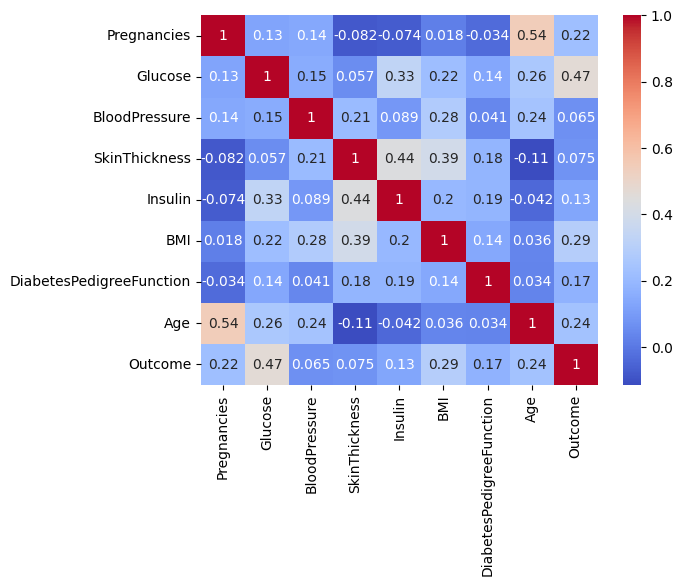

In [36]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

### Drop Duplicate

In [37]:
df.duplicated().sum()

np.int64(0)

In [38]:
df.drop_duplicates(inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Drop Column

In [40]:
df =df.drop(columns='Insulin')

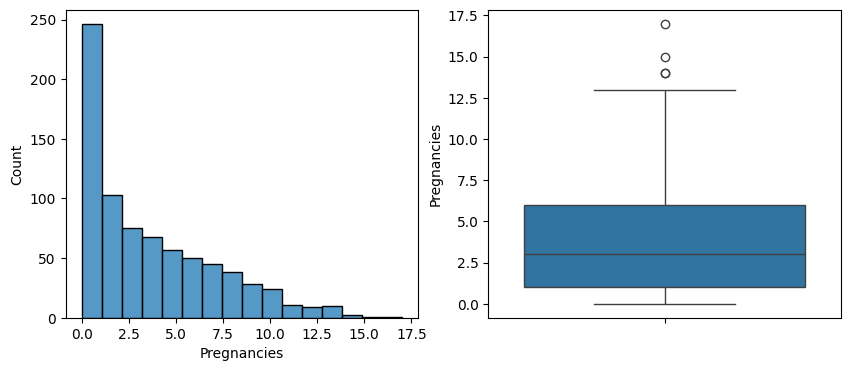

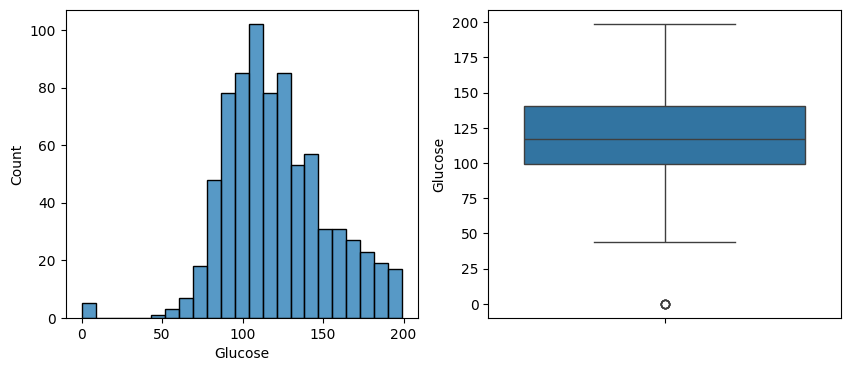

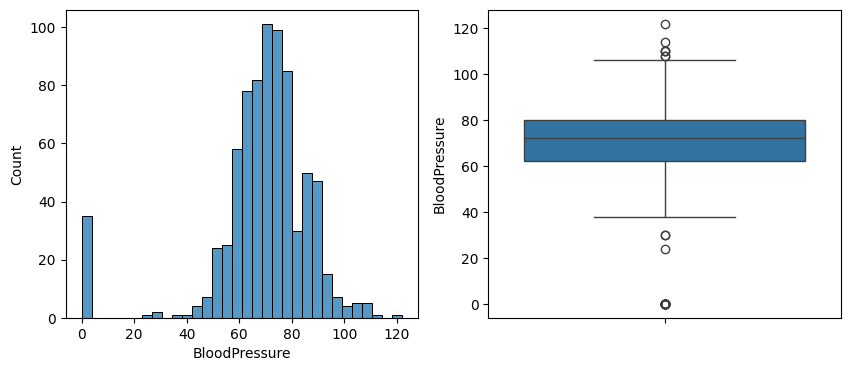

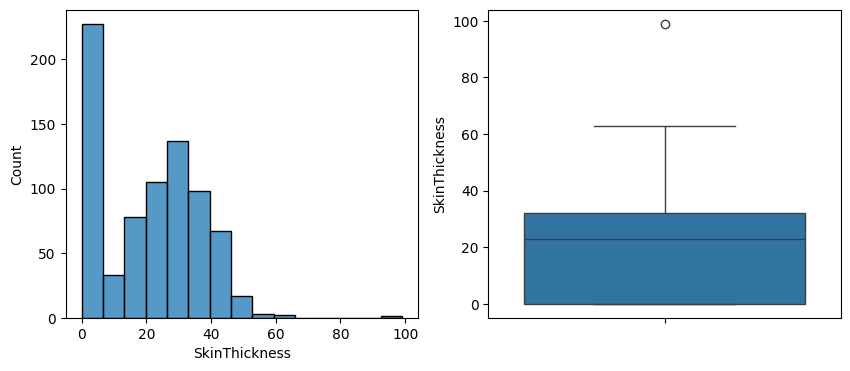

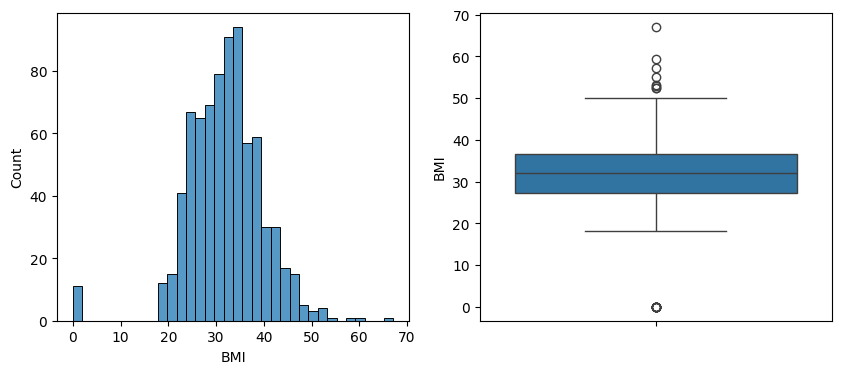

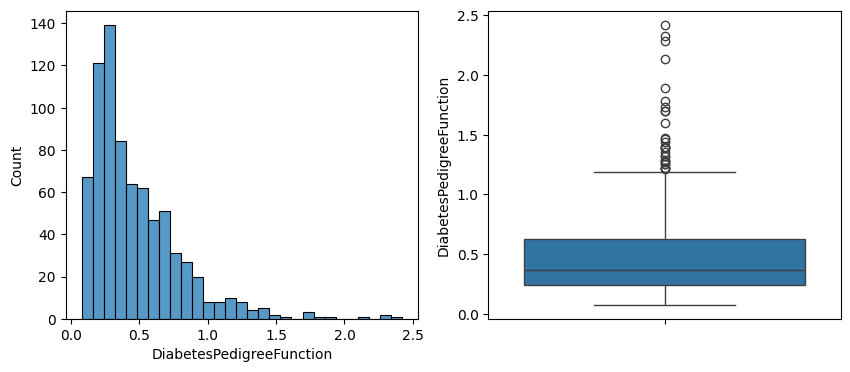

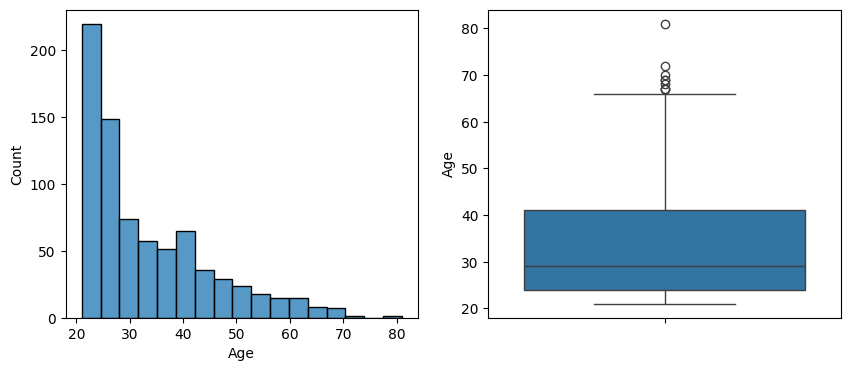

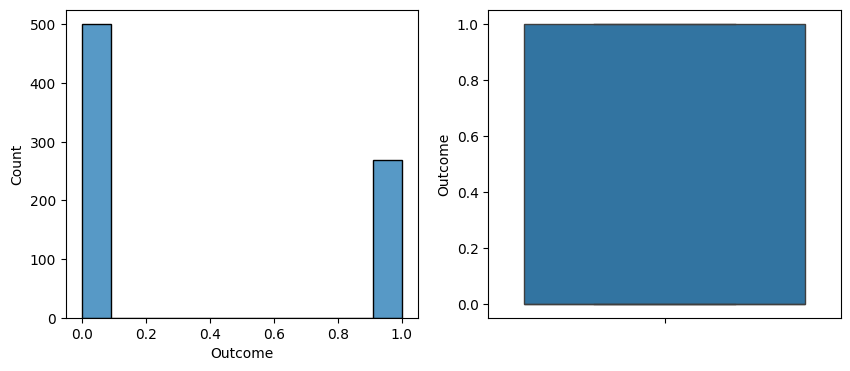

In [41]:
import matplotlib.pyplot as plt

def check_numeric(data, cols):
    for i in cols:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(data[i])
        plt.subplot(1, 2, 2)
        sns.boxplot(data[i])
        plt.show()

num_cols = df.columns.to_list()

check_numeric(df, num_cols)

## Modeling

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

### Split and Handling Unbalance Dataset

In [44]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [46]:
smote = SMOTE(random_state=88)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Hyperparameter Tunning & Train

In [47]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [None, 5, 8, 10, 15],
    'min_samples_split': [2, 5, 8, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=88), param_grid, cv=5, scoring='recall_macro', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
print("Test recall with best model:", best_model.score(X_test, y_test))


Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score: 0.7974683544303798
Test recall with best model: 0.7792207792207793


### Predict and Evaluation

In [48]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       105
           1       0.63      0.76      0.69        49

    accuracy                           0.78       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.80      0.78      0.78       154

Accuracy: 0.7792207792207793


In [49]:
best_model.score(X_test, y_test)

0.7792207792207793

In [50]:
features = pd.DataFrame(best_model.feature_importances_, index=X.columns)

In [51]:
top = features.sort_values(by=0, ascending=False)
top

,0
Glucose,0.272117
BMI,0.184393
Age,0.156471
DiabetesPedigreeFunction,0.150227
BloodPressure,0.092175
SkinThickness,0.078258
Pregnancies,0.066359


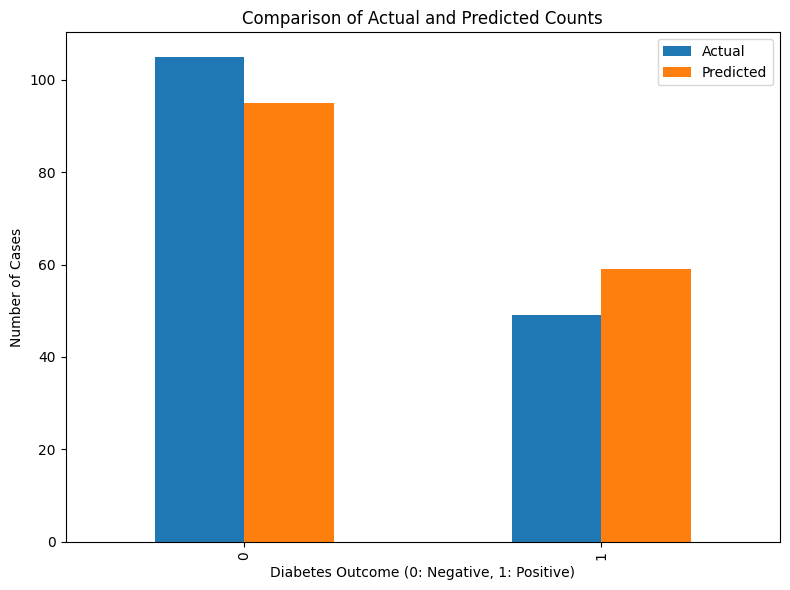

In [52]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
actual_counts = results_df['Actual'].value_counts().sort_index()
predicted_counts = results_df['Predicted'].value_counts().sort_index()

plot_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
})

plot_df.plot(kind='bar', figsize=(8, 6))
plt.title('Comparison of Actual and Predicted Counts')
plt.xlabel('Diabetes Outcome (0: Negative, 1: Positive)')
plt.ylabel('Number of Cases')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.show()

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_proba = best_model.predict_proba(X_test)[:, 1]

new_threshold = 0.4

y_pred_new = (y_pred_proba >= new_threshold).astype(int)

print(f"--- Evaluation with Threshold = {new_threshold} ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_new))
print("\nClassification Report:\n", classification_report(y_test, y_pred_new))

--- Evaluation with Threshold = 0.4 ---
Confusion Matrix:
 [[75 30]
 [ 8 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.80       105
           1       0.58      0.84      0.68        49

    accuracy                           0.75       154
   macro avg       0.74      0.78      0.74       154
weighted avg       0.80      0.75      0.76       154



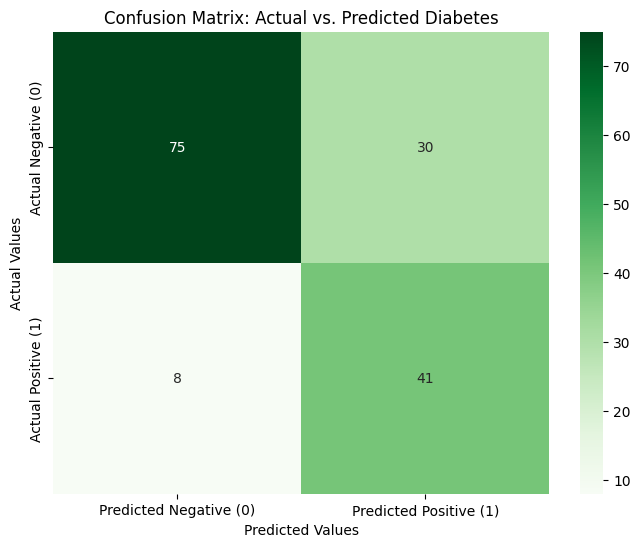

In [54]:
cm = confusion_matrix(y_test, y_pred_new)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Greens',
    xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
    yticklabels=['Actual Negative (0)', 'Actual Positive (1)']
)
plt.title('Confusion Matrix: Actual vs. Predicted Diabetes')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Without Oversampling and Without Hyperparameter Tunning

In [63]:
rf_no_ovr_and_no_tune = RandomForestClassifier(random_state=42)
rf_no_ovr_and_no_tune.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
y_pred_rf_no_ovr_and_no_tune = rf_no_ovr_and_no_tune.predict_proba(X_test)[:, 1]

new_threshold = 0.4

y_pred_rf_no_ovr_and_no_tune_new = (y_pred_rf_no_ovr_and_no_tune >= new_threshold).astype(int)

print(f"--- Evaluation with Threshold = {new_threshold} ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_no_ovr_and_no_tune_new))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_no_ovr_and_no_tune_new))

--- Evaluation with Threshold = 0.4 ---
Confusion Matrix:
 [[77 28]
 [10 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80       105
           1       0.58      0.80      0.67        49

    accuracy                           0.75       154
   macro avg       0.73      0.76      0.74       154
weighted avg       0.79      0.75      0.76       154



### Using Oversampling and Without Tunning

In [61]:
rf_ovr_and_no_tune = RandomForestClassifier(random_state=42)
rf_ovr_and_no_tune.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [62]:
y_pred_rf_ovr_and_no_tune = rf_ovr_and_no_tune.predict_proba(X_test)[:, 1]

new_threshold = 0.4

y_pred_rf_ovr_and_no_tune_new = (y_pred_rf_ovr_and_no_tune >= new_threshold).astype(int)

print(f"--- Evaluation with Threshold = {new_threshold} ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_ovr_and_no_tune_new))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_ovr_and_no_tune_new))

--- Evaluation with Threshold = 0.4 ---
Confusion Matrix:
 [[72 33]
 [ 8 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78       105
           1       0.55      0.84      0.67        49

    accuracy                           0.73       154
   macro avg       0.73      0.76      0.72       154
weighted avg       0.79      0.73      0.74       154



### Without Oversampling and Using Tunning

In [65]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [None, 5, 8, 10, 15],
    'min_samples_split': [2, 5, 8, 10]
}

grid_search_no_ovr = GridSearchCV(RandomForestClassifier(random_state=88), param_grid, cv=5, scoring='recall_macro', n_jobs=-1)
grid_search_no_ovr.fit(X_train, y_train)

print("Best parameters:", grid_search_no_ovr.best_params_)
print("Best cross-validation score:", grid_search_no_ovr.best_score_)

best_model_no_orv = grid_search_no_ovr.best_estimator_
print("Test recall with best model:", best_model_no_orv.score(X_test, y_test))

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.7284796745791742
Test recall with best model: 0.7792207792207793


In [66]:
y_pred_rf_no_ovr_and_tune = best_model_no_orv.predict_proba(X_test)[:, 1]

new_threshold = 0.4

y_pred_rf_no_ovr_and_tune = (y_pred_rf_no_ovr_and_tune >= new_threshold).astype(int)

print(f"--- Evaluation with Threshold = {new_threshold} ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_no_ovr_and_tune))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_no_ovr_and_tune))

--- Evaluation with Threshold = 0.4 ---
Confusion Matrix:
 [[77 28]
 [10 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80       105
           1       0.58      0.80      0.67        49

    accuracy                           0.75       154
   macro avg       0.73      0.76      0.74       154
weighted avg       0.79      0.75      0.76       154



## Save Model

In [57]:
import pickle

save_obj = {
    'model': best_model,
    'threshold': 0.4
}
with open("model_with_threshold.pkl", "wb") as f:
    pickle.dump(save_obj, f)